# Denoising Autoencoder
### A deep convolutional neural network based neural network for removing noise from scanned office documents.

The dataset and its description can be downloaded from: https://archive.ics.uci.edu/ml/datasets/NoisyOffice

#### The goal of the project is to use a deep neural network to remove coffe stains, footprints, marks resulting from folding or wrinkles from scanned office documents. 

#### A brief Description:

    The dataset consists of 18 ground truth images, and 72 noisy images i.e. each clear image simulated with 4 kinds of noise (4*18 = 72). The 72 noisy images divided into training, validation and testing sets.

Every file is named in the format FontABC_NoiseD_EE.png, where:

    A - Size of the font: footnote size (f), normal size (n) o large size (L)
    B - Font type: typewriter (t), sans serif (s) or roman (r)
    C - Yes/no emphasized font (e/m)
    D - Type of noise: folded sheets (Noise f), wrinkled sheets (Noise w), coffee stains (Noise c), and footprints (Noise p)
    E - Data set partition: training (TR), validation (VA), test (TE), real (RE).
    
Importing required libraries

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import cv2

import numpy as np
import torch
import torch.nn as nn
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

We are going to use PyTorch for building the autoencoder, OpenCV for image processing and matplotlib for displaying the images.

### Reading Data

Reading the noisy and clean image file names from the corresponding directories. The dataset already contains train, validation and test splits. The filename of each image indicates which split it corresponds to. 
Image extensions
* `_TR` - Train split
* `_VA`- Validation split
* `_TE` - Test split

Also the real images i.e. images without noise which we will use as ground truth images are given with the extension `_RE`.

The noisy images are in the directory - `simulated_noisy_images_grayscale` and ean images are in the directory `clean_images_grayscale`. We are going to save the names of all images into lists such that each image in the noisy data has corresponding target from the clean images.

In [2]:
def get_files_list(dir_):
    """Reads file names into a list from corresponding directory"""
    train_images = []
    valid_images = []
    test_images = []

    for filename in os.listdir(dir_):
        split = filename.split('.')[0].split('_')[-1]
        if split == 'TR':
            train_images.append(filename)
        elif split == 'VA':
            valid_images.append(filename)
        elif split == 'TE':
            test_images.append(filename)
    return train_images, valid_images, test_images

In [3]:
train_images, valid_images, test_images = get_files_list('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/')
train_targets, valid_targets, test_targets = get_files_list('./data/SimulatedNoisyOffice/clean_images_grayscale/')

Checking the number of images in each split of data, we have 72 noisy images and 18 clean images per split.

In [4]:
print(f"Training Data - Number of noisy images: {len(train_images)}, Number of clean images : {len(train_targets)}")
print(f"Validation Data - Number of noisy images: {len(valid_images)}, Number of clean images : {len(valid_targets)}")
print(f"Test Data - Number of noisy images: {len(test_images)}, Number of clean images : {len(test_targets)}")

Training Data - Number of noisy images: 72, Number of clean images : 18
Validation Data - Number of noisy images: 72, Number of clean images : 18
Test Data - Number of noisy images: 72, Number of clean images : 18


In [5]:
train_images[:8], train_targets[:2]

(['Fontfre_Noisec_TR.png',
  'Fontfre_Noisef_TR.png',
  'Fontfre_Noisep_TR.png',
  'Fontfre_Noisew_TR.png',
  'Fontfrm_Noisec_TR.png',
  'Fontfrm_Noisef_TR.png',
  'Fontfrm_Noisep_TR.png',
  'Fontfrm_Noisew_TR.png'],
 ['Fontfre_Clean_TR.png', 'Fontfrm_Clean_TR.png'])

Each clean image is simulated with 4 different noise types, that is the reason we have 72 noisy and 18 clean images. Which means the first four images in the training set will have one clean image as a target. This can be confirmed by looking at the lists printed above

#### Now looking at the actual noisy and clean images

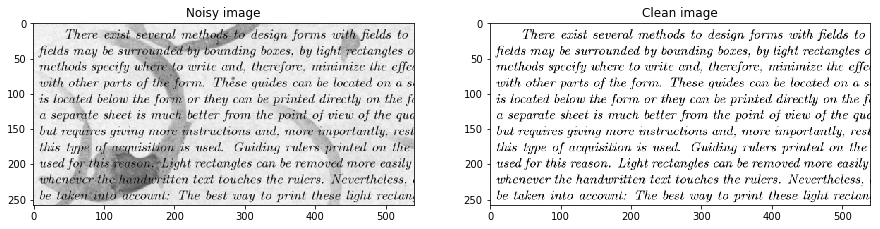

In [6]:
img_noisy = cv2.imread('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[0], 
                       cv2.IMREAD_GRAYSCALE)
img_clean = cv2.imread('./data/SimulatedNoisyOffice/clean_images_grayscale/'+train_targets[0], 
                       cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(img_noisy, cmap='gray')
plt.title("Noisy image")

plt.subplot(122)
plt.imshow(img_clean, cmap='gray')
plt.title("Clean image")
plt.show()

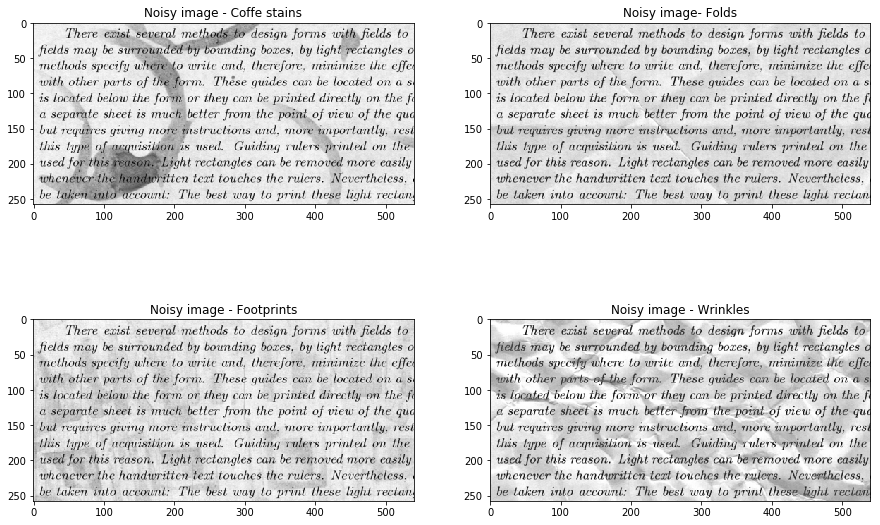

In [7]:
img_noisy_1 = cv2.imread('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[0], 
                         cv2.IMREAD_GRAYSCALE)
img_noisy_2 = cv2.imread('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[1], 
                         cv2.IMREAD_GRAYSCALE)
img_noisy_3 = cv2.imread('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[2], 
                         cv2.IMREAD_GRAYSCALE)
img_noisy_4 = cv2.imread('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+train_images[3], 
                         cv2.IMREAD_GRAYSCALE)


fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(img_noisy_1, cmap='gray')
plt.title("Noisy image - Coffe stains")

plt.subplot(222)
plt.imshow(img_noisy_2, cmap='gray')
plt.title("Noisy image- Folds")

plt.subplot(223)
plt.imshow(img_noisy_3, cmap='gray')
plt.title("Noisy image - Footprints")

plt.subplot(224)
plt.imshow(img_noisy_4, cmap='gray')
plt.title("Noisy image - Wrinkles")
plt.show()

### Data preparation

In order to use an Autoencoder the data needs to be prepared such that the model can access the noisy image and corresponding clean image during training and testing. As we are using Pytorch to build the Denoising Autoencoder we need the data to be in Tensors. The following function reads the noisy and corresponding clean image, resizes all the images to be of same size and returns tensors containing noisy images and clean images.

The function takes in the lists we prepared in the beginning which contain the filenames as inputs. It will read the files and resize all the images to have uniform shape and then normalizes the data by dividing the values by 255. This divison  will make the values range from `(0-1)` rather than ranging from `(0-255)`, which will help with the training. 

In [8]:
def get_tensors(images_list, target_list):
    image_tensors = []
    target_tensors = []
    reference_target_list = [filename.split('_')[0] for filename in target_list]
    for filename in images_list:
        image = filename.split('_')[0]
        if image in reference_target_list:
            idx = reference_target_list.index(image)
            image = cv2.imread('./data/SimulatedNoisyOffice/simulated_noisy_images_grayscale/'+filename, 
                               cv2.IMREAD_GRAYSCALE)
            target = cv2.imread('./data/SimulatedNoisyOffice/clean_images_grayscale/'+target_list[idx], 
                                cv2.IMREAD_GRAYSCALE)
            
            image = cv2.resize(image, (540, 420), interpolation = cv2.INTER_AREA)
            target = cv2.resize(target, (540, 420), interpolation = cv2.INTER_AREA)

            image = torch.from_numpy(image/255).unsqueeze(0)
            target = torch.from_numpy(target/255).unsqueeze(0)
            image_tensors.append(image)
            target_tensors.append(target)

    image_tensors = torch.stack(image_tensors)
    target_tensors = torch.stack(target_tensors)
    return image_tensors, target_tensors

##### Loading data into tensors

In [9]:
train_data, train_targets = get_tensors(train_images, train_targets)
valid_data, valid_targets = get_tensors(valid_images, valid_targets)
test_data, test_targets = get_tensors(test_images, test_targets)

##### Defining a Dataset class in order to efficiently use the Dataloader from Pytorch

In [10]:
class NoisyImagesDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

##### Writing training and evaluation functions

In [11]:
def execute_trainstep(model, device, loader, loss_criterion, optimizer):
    model.train()
    losses = []
    for idx, (noisy, clean) in enumerate(loader):
        
        noisy = noisy.to(device)
        clean = clean.to(device)
        
        optimizer.zero_grad()
        
        out = model(noisy)
        loss = loss_criterion(out, clean)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
    return np.mean(losses)

def validate(model, device, loader, loss_criterion):
    model.eval()
    losses = []
    for idx, (noisy, clean) in enumerate(loader):
        
        noisy = noisy.to(device)
        clean = clean.to(device)
        
        out = model(noisy)
        
        loss = loss_criterion(out, clean)
        losses.append(loss.item())
    
    return np.mean(losses) 

### Denoising Autoencoder

The autoencoder consistes of two parts, an encoder and a decoder. The Encoder compresses the image into lower dimensions capturing the details and the Decoder builds the image from this compressed representation. We are going to use an all convolutional autoencoder in this case. That means we will not be using fully connected layers in between the encoder and decoder.

Training the auto encoder by giving noisy images as input and clean images as a reference to learn from. The Encoder will compress the image and the Decoder will decode the compressed representation in such a way that it cleans the image.

In [12]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 12, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 24, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 64, 1),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 24, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(24, 12, 3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(12, 6, 3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(6, 1, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
torch.cuda.empty_cache()

### Hyperparameters and Evaluation Metric

We can now set the hyperparameters such as number of epochs, learning rate, batch size. 

Mean Squared Error (**MSE**) is chosen as an evaluation metric here for calculating how far the noisy image is from the clean image. In a way this represents the amount of noise present in the image. The autoencoder will be trained to reduce the distance between the noisy image and the clean image. This will enable the autoencoder to learn features that will cancel out the noise from the noisy images.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001
epochs = 30
batch_size = 2

train_dataset = NoisyImagesDataset(train_data, train_targets)
valid_dataset = NoisyImagesDataset(valid_data, valid_targets)
test_dataset = NoisyImagesDataset(test_data, test_targets)

train_loader = torch.utils.data.dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.dataloader.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.dataloader.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


model = DenoisingAutoEncoder().to(device).double()
loss_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

### Training and Validation

The model parameters are updated based on the error obtained on the training data. A validation set is used to evaluate the performance of the model on unseen data.

In [15]:
train_losses = []
valid_losses = []

for epoch in range(1, epochs+1):
    train_losses.append(execute_trainstep(model, device, train_loader, loss_criterion, optimizer))
    valid_losses.append(validate(model, device, valid_loader, loss_criterion))
    
    print(f"Epoch {epoch}/{epochs} Training Loss : {train_losses[-1]:.6f} Validation Loss : {valid_losses[-1]:.6f}")

Epoch 1/30 Training Loss : 0.108374 Validation Loss : 0.071887
Epoch 2/30 Training Loss : 0.065459 Validation Loss : 0.057349
Epoch 3/30 Training Loss : 0.042469 Validation Loss : 0.033426
Epoch 4/30 Training Loss : 0.028980 Validation Loss : 0.026002
Epoch 5/30 Training Loss : 0.021732 Validation Loss : 0.019528
Epoch 6/30 Training Loss : 0.016649 Validation Loss : 0.014651
Epoch 7/30 Training Loss : 0.012799 Validation Loss : 0.011750
Epoch 8/30 Training Loss : 0.009892 Validation Loss : 0.009340
Epoch 9/30 Training Loss : 0.007832 Validation Loss : 0.007736
Epoch 10/30 Training Loss : 0.006272 Validation Loss : 0.007025
Epoch 11/30 Training Loss : 0.005876 Validation Loss : 0.005977
Epoch 12/30 Training Loss : 0.005410 Validation Loss : 0.005506
Epoch 13/30 Training Loss : 0.004685 Validation Loss : 0.005393
Epoch 14/30 Training Loss : 0.004743 Validation Loss : 0.005191
Epoch 15/30 Training Loss : 0.004371 Validation Loss : 0.004677
Epoch 16/30 Training Loss : 0.004253 Validation L

##### Plotting the Training and Validation errors

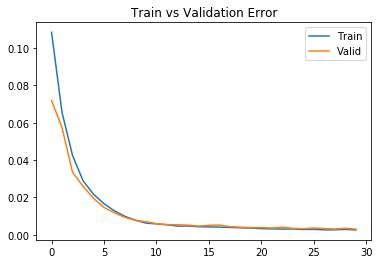

In [16]:
plt.plot(train_losses, label ='Train')
plt.plot(valid_losses, label ='Valid')
plt.title("Train vs Validation Error")
plt.legend()
plt.show()

## Testing

Now that the model is trained and validated, we can test it on Test data. Usually this test data is never seen by the model and will give us a better understanding on how well the model will perform in the real world when it is deployed.

In [17]:
# We can use the same validation function we wrote earlier for Testing
test_error = validate(model, device, test_loader, loss_criterion)
print(f"Test Error : {test_error:.6f}")

Test Error : 0.002911


The test error is close to the validation and training errors which we obtained above, So we can say that the model is performing similarly on the testing data as it has on training and validation data.

#### Now let us see whether it actually removes any noise from the images

In [18]:
def denoise(test_data, i, denoise):
    out = model(test_data[i].unsqueeze_(0).to(device))
    out = out.detach().squeeze(0).squeeze(0).cpu().numpy()
    
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.imshow(test_data[i].squeeze(0).numpy(), cmap='gray')
    plt.title("Noisy image")

    plt.subplot(122)
    plt.imshow(out, cmap='gray')
    plt.title("Cleaned image")
    plt.show()

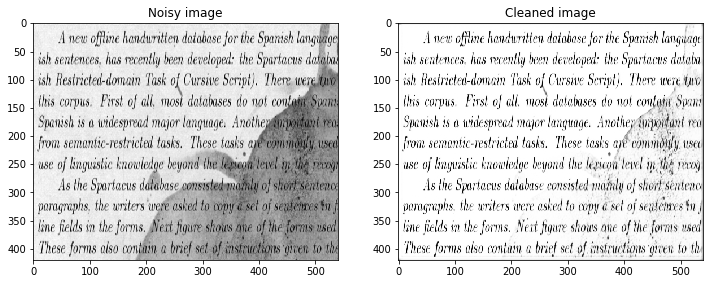

In [19]:
denoise(test_data, 0, device)

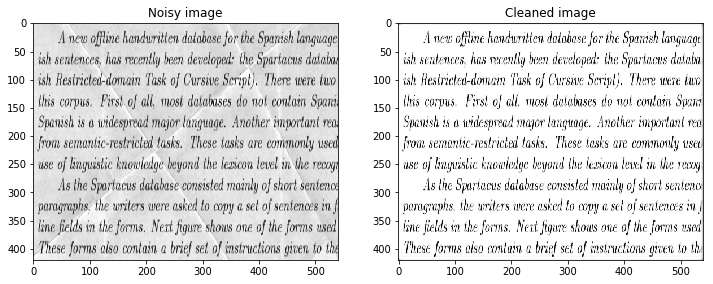

In [20]:
denoise(test_data, 1, device)

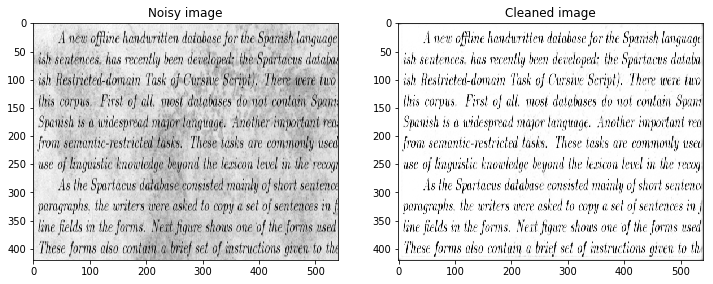

In [21]:
denoise(test_data, 2, device)

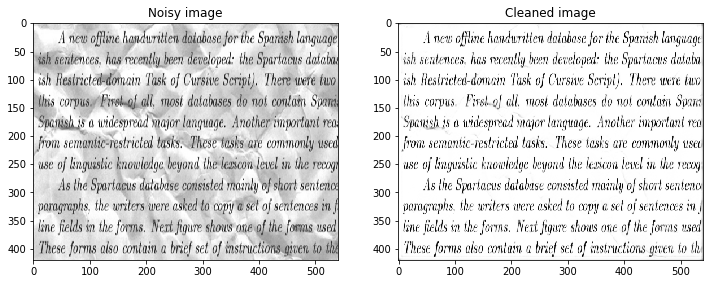

In [22]:
denoise(test_data, 3, device)

### Conclusion

As seen, the model removes wrinkles and folds from the noisy images and still struggles to remove coffee stains and footprints. The performance can be still improved by choosing a bigger network and tuning the hyperparameters.